In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import os
import cv2
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data_dir = "/content/drive/MyDrive/training_set"  # Data directory
image_size = (150, 150)  # Image size

# Load and label the images
images = []
labels = []

# Load images labeled as "cats"
cats_images = os.listdir(os.path.join(data_dir, "cats"))
for img_name in cats_images:
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(data_dir, "cats", img_name), target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img_array)
    labels.append(0)  # Label the image as 0 to represent cats

# Load images labeled as "dogs"
dogs_images = os.listdir(os.path.join(data_dir, "dogs"))
for img_name in dogs_images:
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(data_dir, "dogs", img_name), target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img_array)
    labels.append(1)  # Label the image as 1 to represent dogs

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Convert data values to [0, 1] range
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Step 2: Define the standard deep learning model
model_standard = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the standard model
model_standard.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Step 3: Train the standard deep learning model
history_standard = model_standard.fit(train_images, train_labels, epochs=10,
                                      validation_data=(test_images, test_labels))

# Step 4: Define the approximate Bayesian deep learning model with Monte Carlo dropout
class MC_Dropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

model_bayesian = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    MC_Dropout(rate=0.5),  # Monte Carlo dropout layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the Bayesian model
model_bayesian.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Step 5: Train the approximate Bayesian deep learning model with Monte Carlo dropout
history_bayesian = model_bayesian.fit(train_images, train_labels, epochs=10,
                                      validation_data=(test_images, test_labels))

# Step 6: Evaluate both models and calculate standard deviation for the Bayesian model
test_loss_standard, test_accuracy_standard = model_standard.evaluate(test_images, test_labels)
test_loss_bayesian, test_accuracy_bayesian = model_bayesian.evaluate(test_images, test_labels)

print("Standard Model Test Accuracy:", test_accuracy_standard)
print("Bayesian Model Test Accuracy:", test_accuracy_bayesian)

# Monte Carlo dropout for approximate Bayesian inference
def mc_dropout_predict(model, X_test, num_samples):
    y_preds = np.stack([model.predict(X_test) for _ in range(num_samples)], axis=0)
    y_mean = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)
    return y_mean, y_std

num_samples_mc_dropout = 50  # Number of Monte Carlo samples
y_mean_mc_dropout, y_std_mc_dropout = mc_dropout_predict(model_bayesian, test_images, num_samples_mc_dropout)

# Calculate standard deviation
std_dev_mc_dropout = np.mean(y_std_mc_dropout)

print("Standard Deviation of Bayesian Model (Monte Carlo Dropout):", std_dev_mc_dropout)

Epoch 1/10
75/75 [==============================] - 11s 49ms/step - loss: 0.7036 - accuracy: 0.4950 - val_loss: 0.6921 - val_accuracy: 0.4767
Epoch 2/10
75/75 [==============================] - 2s 26ms/step - loss: 0.6901 - accuracy: 0.5204 - val_loss: 0.6884 - val_accuracy: 0.5250
Epoch 3/10
75/75 [==============================] - 2s 28ms/step - loss: 0.6813 - accuracy: 0.5521 - val_loss: 0.6672 - val_accuracy: 0.5917
Epoch 4/10
75/75 [==============================] - 2s 28ms/step - loss: 0.6504 - accuracy: 0.6209 - val_loss: 0.6557 - val_accuracy: 0.6217
Epoch 5/10
75/75 [==============================] - 2s 32ms/step - loss: 0.6164 - accuracy: 0.6651 - val_loss: 0.6527 - val_accuracy: 0.6217
Epoch 6/10
75/75 [==============================] - 2s 29ms/step - loss: 0.5885 - accuracy: 0.6802 - val_loss: 0.6598 - val_accuracy: 0.6350
Epoch 7/10
75/75 [==============================] - 2s 26ms/step - loss: 0.5412 - accuracy: 0.7198 - val_loss: 0.6366 - val_accuracy: 0.6450
Epoch 8/10
7

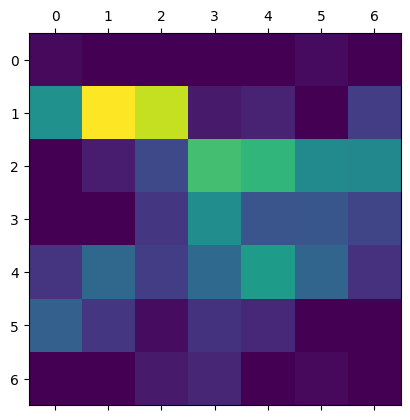

In [4]:
from typing_extensions import NewType
import keras
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
new_images = np.expand_dims(test_images[0], axis=0)
img_array = new_images

# Make model
model = model_standard

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = test_labels[0]


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, "max_pooling2d_3")

# Display heatmap
plt.matshow(heatmap)
plt.show()